In [1]:
#IMPORTS

import xarray as xr
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sc
import torch
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.utils.data as data_utils
from torch.nn import Linear
from torch.functional import F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Tanh
from tqdm import tqdm

import matplotlib.pyplot as plt
import csv

from itertools import combinations, permutations, product
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Process, Pool
#from ray import tune

In [2]:
#RANDOM SEEDING

%matplotlib inline
torch.manual_seed(21985)
np.random.seed(21985)

In [3]:
#LOADING DATA

# Data from Sean's version of Hugh's Tau model
path = 'singlecatdata'
ncfile = 'offline_singlecat_1spaced_referencedetail.nc'

ncfilepath=os.path.join(path,ncfile)

nc=xr.open_dataset(ncfilepath)

nc['ccoal'].stack(y=('altitude','case','time'))
nc

<xarray.Dataset>
Dimensions:                        (altitude: 20, bin_edge_mass: 36, bin_mass: 35, case: 16, cloud_moment: 16, rain_moment: 0, time: 721)
Coordinates:
  * altitude                       (altitude) float64 0.0 100.0 ... 1.9e+03
  * time                           (time) float64 0.0 5.0 ... 3.595e+03 3.6e+03
  * cloud_moment                   (cloud_moment) int32 -3 -2 -1 0 ... 10 11 12
  * rain_moment                    (rain_moment) int32 
  * bin_mass                       (bin_mass) float64 2.397e-14 ... 0.0004118
  * bin_edge_mass                  (bin_edge_mass) float64 1.598e-14 ... 0.00...
Dimensions without coordinates: case
Data variables: (12/39)
    nccn                           (case) float64 ...
    rhinit                         (case) float64 ...
    lhflux                         (case) float64 ...
    ampw                           (case) float64 ...
    tperiod                        (case) float64 ...
    pressure                       (case, altitude) float64 ...
    ...                             ...
    total_precipitation_number     (case) float64 ...
    total_precipitation_amount     (case) float64 ...
    first_peak_precipitation_rate  (case) float64 ...
    first_peak_precipitation_time  (case) float64 ...
    dsd_number                     (case, time, altitude, bin_mass) float64 ...
    dsd_mass                       (case, time, altitude, bin_mass) float64 ...

In [4]:
#Data Array for output storage

#define the data array
global dataArray
dataArray = np.empty(shape=(0,6))

In [5]:
#LOAD TAU DATA

def loadtaudata(process, moments_used=[0,1,2,3,4,5,6,7], dMdt_output=[0,1,2,3,4,5,6,7]):
    ### [] process is an integer that indicates which process rate we are interested in fitting
    # 0 - cond/evap, 1 - activation, 2 - collision-coalescence (self-collection), 3 - sedimentation
    # these are the order the processes are applied in the Tau model
    
    ### [] moments_used is a list of the moments that are to be trained on. i.e. [2,3,4] 
    
    proc_rates = ['cevap','act','ccoal','csed']
    #proc_rates = 'ccoal'
    env_var = ['nccn','theta','rel_hum','pressure']
    cloud_params = 'cliq_mom'
    
    ncfilepath=os.path.join(path,ncfile)
    nc=xr.open_dataset(ncfilepath)
    
    proc_rate = proc_rates[process]
    
    rates = nc[proc_rate].stack(y=('altitude','case','time'))
    corrmoments = nc[cloud_params] 
    
    cloud_moments = rates.cloud_moment
    nsamp = len(rates.y)
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #correct the moments at each time step for the processes applied in Tau up to this process is calculated 
    for i in range(0,process):
        corr_proc_rate = proc_rates[i]
        corrmoments = corrmoments - nc[corr_proc_rate]    
    
    moments = corrmoments.to_dataset(name=cloud_params).stack(y=('altitude','case','time'))

    #Compute rough scaling factors 
    
    #calculates average value of each moment for each nonzero value.
    momscale = []
    for i in range(nmoms):
        matrix = nc[cloud_params][:,moments_used[i],:,:]
        moments_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        momscale.append(moments_mean)
    #print(momscale)

    #calculates average value of dMdt for each nonzero value
    dmomscale = []
    for i in range(ndmoms):
        matrix = nc[proc_rate][:,dMdt_output[i],:,:]
        dMdt_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        dmomscale.append(dMdt_mean)
    #print(dmomscale)
    
    #hard coded values for moments [0,3,6]
    #momscale = [1e7,1e-6,1e-15]
    #dmomscale = [1e5,1e-24,1e-17]

    #normalizing procedure 
    dMdt = np.zeros((nsamp,ndmoms))
    M = np.zeros((nsamp,nmoms))
    for c in range(ndmoms):
        targetdata = rates.isel(cloud_moment=dMdt_output[c]+3).to_dataframe()
        #dMdt[:,c] = targetdata[proc_rate].to_numpy()/dmomscale[c]
        dMdt[:,c] = targetdata[proc_rate].to_numpy()
    for c in range(nmoms):
        momentdata = moments.isel(cloud_moment= moments_used[c]+3).to_dataframe()
        #M[:,c] = momentdata[cloud_params].to_numpy()/momscale[c]
        M[:,c] = momentdata[cloud_params].to_numpy()
        
    allvars = set(nc.data_vars)
    dropvars = allvars - set(env_var)
    
    nc = nc.drop_vars(dropvars)
    nc = nc.drop_dims(['rain_moment','cloud_moment', 'bin_mass', 'bin_edge_mass'])
    
    env = nc.stack(y=('altitude','case','time'))
    env = env.to_dataframe().to_numpy()

    
    #appends environmental vars to the array: nccn, pressure, theta, rel_hum
    #predictors = np.concatenate((M,env),axis=1)
    
    #does not include env vars (in theory should not affect ccoal too strongly)
    predictors = M

    targets = dMdt
    
    return predictors,targets

In [6]:
#DEFINE CloudDataset

class CloudDataset(Dataset):
    def __init__(self,Xdata,Ydata,device):
        self.x = Xdata
        self.y = Ydata
        self.device = device

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.x[idx,:]
        Y = self.y[idx,:]
        
        sample = {'X':torch.from_numpy(X).to(device),'Y':torch.from_numpy(Y).to(device)}

        return sample

In [7]:
#Define Microphysics Emulator

class MicroEmulator(torch.nn.Module):
    def __init__(self,n_inputs=3,n_hidden=50,n_outs=3, n_hiddenlayers = 2, activation='ReLU'):
        super(MicroEmulator, self).__init__()
        actfn = ReLU()
        if activation == 'ReLU':
            actfn = ReLU()
        elif activation == 'Tanh':
            actfn = Tanh()
            
        self.first = Seq(Lin(n_inputs, n_hidden), actfn)
        self.last = Lin(n_hidden,n_outs)
        self.layer = Seq(Lin(n_hidden, n_hidden), actfn)
        self.n_hiddenlayers = n_hiddenlayers
        
    def forward(self, x):
        x = self.first(x)
        for i in range(self.n_hiddenlayers):
            x = self.layer(x)
        dMdt = self.last(x)
        return dMdt

In [8]:
#train, test, inference

def train(model,dataloader,criterion,device, optimizer):
    model.train()
    for data in dataloader:
        X = data['X'].float()
        Y = data['Y'].float()
        #X = X.to(device)
        #Y = Y.to(device)
        out = model(X)
        loss = criterion(out,Y)
        loss.backward()
        optimizer.step()
        #sched.step()
        optimizer.zero_grad()
    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            X = data['X'].float()
            Y = data['Y'].float()
            #X = X.to(device)
            #Y = Y.to(device)
            out = model(X)
            loss = criterion(out,Y)
            correct = correct+loss

        return correct #/len(dataloader.dataset)
def inference(model,loader,device, ndmoms):
    model.eval()
    dataset = loader.dataset
    ntargets = ndmoms
    pred = np.zeros((len(dataset),ntargets))
    real = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0
    for data in enumerate(loader):
        #print(i[0],i[1]['X'].shape)

        X = data[1]['X'].float()
        Y = data[1]['Y'].float()

        #X = X.to(device)
        #Y = Y.to(device)

        out = model(X)
        #print(out.shape)
        bs = out.size(0)
        if out is not(None):
            #assert(Y.shape[0]==20),print(jj)
            #print(i,bs,Y.shape)
            real[jj:jj+bs,:]=Y.cpu().detach().numpy().reshape(bs,ntargets)
            pred[jj:jj+bs,:]=out.cpu().detach().numpy().reshape(bs,ntargets)
            jj=jj+bs
            i = i+1
        else:
            break

    return real,pred

In [9]:
#Defines trim_data, a function for filtering and scaling the data according to our specifications
#after it is generated by load_tau_data(). 

def trim_data(pred, tar, moments_used, dMdt_output, log=False):
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
        
    ###Masking of Data
    
    #combine pred and tar to a single DataFrame
    df_pred = pd.DataFrame(pred)
    df_tar = pd.DataFrame(tar)
    df = pd.concat([df_pred, df_tar], axis=1)
    
    #gives the dataframe correct column labels (environmental variables are hardcoded for now)
    pred_cols = ['M'+str(i) for i in moments_used] #+ ['nccn', 'pressure', 'theta', 'rel_hum']
    tar_cols = ['dM'+str(i)+'/dt' for i in dMdt_output]
    df.columns = pred_cols + tar_cols
    
    #remove all datapoints where M0 is less than M0limit and M3 is less than M3limit (not considered a cloud)
    M0limit = 1e-2
    M3limit = 1e-15/(1000.*np.pi/6)
    df = df.drop(df[(df.M0 < M0limit) | (df.M3 < M3limit)].index)
    
    #"clip" all moments to be equal to the minimum value of 5 orders of magnitude beneath the maximum value
    for moment_idx in moments_used:
        mom = 'M'+str(moment_idx)
        min_threshold = df.loc[:,mom].max()/1e5
        df.loc[df[mom]<min_threshold, mom] = min_threshold
    
    #applies a logarithm to the moment data
    if log:
        for moment_idx in moments_used:
            mom = 'M' + str(moment_idx)
            df[mom] = np.log10(np.abs(df[mom]))

# Had issues with taking log10 of 0 valued dMX/dt's. 

#         for dmoment_idx in dMdt_output:
#             dmom ='dM' + str(3*dmoment_idx-6)+'/dt'
#             df[dmom] = np.log10(abs(df[dmom]))
        
    df_pred = df[pred_cols].copy()
    df_tar = df[tar_cols].copy()
    
    predfiltered = df_pred.to_numpy()
    tarfiltered = df_tar.to_numpy()
    
    #Scales predictor values to between 0 and 1
    scaler_pred = preprocessing.MinMaxScaler()
    predrescaled = scaler_pred.fit_transform(predfiltered)

    #Scales target values to between 0 and 1
    scaler_tar = preprocessing.MinMaxScaler()
    tarrescaled = scaler_tar.fit_transform(tarfiltered)
    
    return predrescaled, tarrescaled, scaler_pred, scaler_tar

In [10]:
#Defines make_prediction(). Trains a neural network on a set of predictors and outputs specified.

#array values are the moment numbers themselves

### Change this list as needed for the run ###

def make_prediction(chosen_params, moments_used, dMdt_output, device="cpu"):
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #load tau data
    #2 since we are interested in self-collection/collision-coalescence
    pred,tar = loadtaudata(2,moments_used,dMdt_output)
    
    predrescaled, tarrescaled, scaler_pred, scaler_tar = trim_data(pred, tar, moments_used, dMdt_output, log=True)
    
    # Split into test, train, val
    idx = np.arange(0,predrescaled.shape[0])
    selidx = idx #np.random.choice(idx,size=50000)

    X_train, X_test, y_train, y_test = train_test_split(predrescaled[selidx,:],tarrescaled[selidx,:],test_size = 0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.25, random_state=42)
    #print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

    traindataset = CloudDataset(X_train,y_train,device)
    valdataset = CloudDataset(X_val,y_val,device)
    testdataset = CloudDataset(X_test,y_test,device)

    # Check if there is a gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)) ???
    trainloader = DataLoader(traindataset,batch_size=20,shuffle=True,num_workers=0)
    valloader = DataLoader(valdataset,batch_size=20,shuffle=True,num_workers=0)
    testloader = DataLoader(testdataset,batch_size=20,shuffle=True,num_workers=0)

    # Instantiate the neural network (n_inputs increased when including the env vars)
    n_inputs = predrescaled.shape[1]
    n_outputs = tarrescaled.shape[1]
    model = MicroEmulator(n_inputs=n_inputs, 
                          n_outs=n_outputs, 
                          n_hidden=chosen_params['layer_width'], 
                          n_hiddenlayers=chosen_params['layers'],
                          activation=chosen_params['activation'])
    
    ### HYPERPARAMETERS ###
    #lr = 1e-4 formerly
    init_lr = chosen_params['init_lr']
    weight_decay = chosen_params['weight_decay']
    total_epochs = chosen_params['epochs']

    # Learning rate strings so its in the correct format for the filenames
    lrval='{:3.0e}'.format(init_lr)[0]
    lrexp = '{:3.0e}'.format(init_lr)[4]

    #print(model)
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    val_accur = []
    train_accur = []
    
    for epoch in tqdm(range(0,total_epochs)):
        model = train(model,trainloader,criterion,device, optimizer)
        train_acc = test(model,trainloader,criterion,device)
        val_acc = test(model,valloader,criterion,device)
        val_accur.append(val_acc)
        train_accur.append(train_acc)
        #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.8f}, Val. Acc: {val_acc:.8f}')

    
    # plt.figure(figsize=(10, 6))
    # plt.plot(train_accur)
    # plt.plot(val_accur)
    # plt.yscale('log')
    # plt.ylabel("Loss", fontsize=20)
    # plt.xlabel("Epochs", fontsize=20)
    # plt.close()
    
    trainreal,trainpred=inference(model,trainloader,device, ndmoms)
    valreal,valpred=inference(model,valloader,device, ndmoms)
    testreal,testpred=inference(model,testloader,device, ndmoms)

#     print(np.array(moments_used), "predicting", np.array(dMdt_output))
#     for i in range(testreal.shape[1]):
#         print(str(3*moments_used[i]-6))
#         print(str(mean_squared_error(testreal[:,i],testpred[:,i])))
#         print(str(mean_absolute_error(testreal[:,i],testpred[:,i])) + "\n")
    
    ###writes a row of MSE performance data to the DataArray file
    moments = [str(dMdt_output[i]) for i in range(testreal.shape[1])]
    testreal = np.nan_to_num(testreal)
    testpred = np.nan_to_num(testpred)
    MSE_data = [str(mean_squared_error(testreal[:,i],testpred[:,i])) for i in range(testreal.shape[1])]
    row = moments + MSE_data
    global dataArray
    dataArray = np.vstack((dataArray,np.array(row)))


    #Displays inference plots for each moment
#     fig, axs = plt.subplots(nrows=1, ncols=ndmoms, figsize=(16,4))
#     plt.subplots_adjust(hspace=0.4)
#     for i in range(ndmoms):
#         ax0 = axs[i]
#         ax0.set_title('dM'+str(dMdt_output[i]) +'dt')
#         ax0.scatter(trainreal[:,i],trainpred[:,i],s=3,label='Train')
#         ax0.scatter(testreal[:,i],testpred[:,i],s=3,label='Test')
#         ax0.set_xlabel("True")
#         ax0.set_ylabel("Predicted")
#         ax0.set_xlim(0,1.1)
#         ax0.set_ylim(0,1.1)
#         ax0.legend()
#     fig.suptitle('Single Category NN Inference Plot')
#     phrase = "_".join([str(i) for i in moments_used])
#     plt.savefig("SingCatRegression_M" + phrase + ".png")
#     plt.show()
#     plt.close()
    return model, row

In [12]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {'init_lr': [1e-4], 
       'weight_decay': [1e-8], 
       'layers': [3],
       'layer_width': [200],
       'activation': ['ReLU'],
       'epochs': [100]}
def runPrediction(i, j):
    chosen_params = {'init_lr': params['init_lr'][i[0]],
                     'weight_decay': params['weight_decay'][i[1]],
                     'layers': params['layers'][i[2]],
                     'layer_width': params['layer_width'][i[3]],
                     'activation': params['activation'][i[4]],
                     'epochs': params['epochs'][i[5]]
                    }
    
    inputs = [0,3] + list(j)
    outputs = [0] + list(j)
    mod, row = make_prediction(chosen_params, moments_used=inputs, dMdt_output=outputs, device=device)
    Mstring = '_'.join([str(x) for x in j])
    modelfile = Mstring+'_model.pth'
    path = os.getcwd() + '/trained_models/' + modelfile
    torch.save(mod, path)
    return row + list(chosen_params.values())

listlists = [[j for j in range(len(params[i]))] for i in params.keys()]
hyperlist = [list(element) for element in product(*listlists)]
possible_inputs = [-2,-1,1,2,4,5,6,7,8,9,10]
combos = combinations(possible_inputs,2)
runPrediction(hyperlist[0], list(combos)[0])

100%|██████████| 100/100 [22:17<00:00, 13.37s/it]


['0',
 '-2',
 '-1',
 '0.00036622907273063063',
 '3.3453978605395225e-05',
 '0.00016727983412046586',
 0.0001,
 1e-08,
 3,
 200,
 'ReLU',
 100]

In [12]:
#######################
###MOMENT Exploration (with fixed hyperparams)
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#hyperparam optimization of the NN.
params = {'init_lr': [1e-4], 
       'weight_decay': [1e-8], 
       'layers': [3],
       'layer_width': [200],
       'activation': ['ReLU'],
       'epochs': [100]}
def runPrediction(i, j):
    chosen_params = {'init_lr': params['init_lr'][i[0]],
                     'weight_decay': params['weight_decay'][i[1]],
                     'layers': params['layers'][i[2]],
                     'layer_width': params['layer_width'][i[3]],
                     'activation': params['activation'][i[4]],
                     'epochs': params['epochs'][i[5]]
                    }
    
    inputs = [0,3] + list(j)
    outputs = [0] + list(j)
    mod, row = make_prediction(chosen_params, moments_used=inputs, dMdt_output=outputs, device=device)
    Mstring = '_'.join([str(x) for x in j])
    modelfile = Mstring+'_model.pth'
    path = os.getcwd() + '/trained_models/' + modelfile
    #torch.save(mod, path)
    return row + list(chosen_params.values())

listlists = [[j for j in range(len(params[i]))] for i in params.keys()]
hyperlist = [list(element) for element in product(*listlists)]## get something that selects all the correct indices of the hyperparams as a big list, then it can be run in parallel
possible_inputs = [-2,-1,1,2,4,5,6,7,8,9,10]
combos = combinations(possible_inputs,2)

print(f'starting computations on {multiprocessing.cpu_count()} cores')
###PARALLELIZATION
start = time.time()
result = Parallel(n_jobs=32,verbose=10)(delayed(runPrediction)(hyperlist[0], j) for j in list(combos))
end = time.time()
print('{:.2f} s taken'.format(end-start))
print(result)

# Writes to .csv file
#assumes 4 moment scheme.
header = ["Moment 1", "Moment 2", "Moment 3", "Value 1", "Value 2", "Value 3"] + ["init_lr", "weight_decay", "layers", "layer_width", "activation", "epochs"]

with open('4-moment-.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(header)
    writer.writerows(result)

starting computations on 32 cores


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   4 out of  55 | elapsed: 41.6min remaining: 530.2min
[Parallel(n_jobs=32)]: Done  10 out of  55 | elapsed: 42.3min remaining: 190.3min
[Parallel(n_jobs=32)]: Done  16 out of  55 | elapsed: 43.0min remaining: 104.8min
[Parallel(n_jobs=32)]: Done  22 out of  55 | elapsed: 43.7min remaining: 65.5min
[Parallel(n_jobs=32)]: Done  28 out of  55 | elapsed: 45.1min remaining: 43.5min
[Parallel(n_jobs=32)]: Done  34 out of  55 | elapsed: 80.0min remaining: 49.4min
[Parallel(n_jobs=32)]: Done  40 out of  55 | elapsed: 82.4min remaining: 30.9min
[Parallel(n_jobs=32)]: Done  46 out of  55 | elapsed: 83.3min remaining: 16.3min
[Parallel(n_jobs=32)]: Done  52 out of  55 | elapsed: 84.6min remaining:  4.9min


5151.61 s taken
[['0', '-2', '-1', '8.039549864193934e-05', '8.519747272039132e-06', '3.361065665380929e-05', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '1', '5.591439099437676e-05', '5.301621624926058e-06', '3.59835355499825e-05', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '2', '2.9933670791679685e-05', '5.8019362059442505e-06', '1.1769424972368902e-05', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '4', '6.24454768520992e-05', '4.511636995008299e-06', '3.2194804447906113e-06', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '5', '3.357377092844903e-05', '4.6064050730421235e-06', '1.57836094391208e-06', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '6', '3.155091832708496e-05', '4.8913518649934e-06', '1.2396835389754459e-06', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '7', '8.243108088574297e-05', '8.910972252830707e-06', '1.4216666304979052e-06', 0.0001, 1e-08, 2, 150, 'ReLU', 200], ['0', '-2', '8', '8.868587944360078e-05', '1.0204165081920631e-05', '1.499413

[Parallel(n_jobs=32)]: Done  55 out of  55 | elapsed: 85.9min finished


In [23]:
#######################
###HYPERPARAMETER EXPLORATION
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#hyperparam optimization of the NN.
params = {'init_lr': [1e-5,1e-4,1e-3], 
       'weight_decay': [1e-8,1e-7,1e-6], 
       'layers': [2,3,5,10],
       'layer_width': [25,50,100,150],
       'activation': ['ReLU', 'Tanh'],
       'epochs': [200]}
def runPrediction(i):
    chosen_params = {'init_lr': params['init_lr'][i[0]],
                     'weight_decay': params['weight_decay'][i[1]],
                     'layers': params['layers'][i[2]],
                     'layer_width': params['layer_width'][i[3]],
                     'activation': params['activation'][i[4]],
                     'epochs': params['epochs'][i[5]]
                    }
    
    inputs = [0,3,5,8] #Moments 0,3,6,9
    outputs = [0,5,8]
    mod, row = make_prediction(chosen_params, moments_used=inputs, dMdt_output=outputs, device=device)
    Mstring = '_'.join([str(x) for x in i])
    modelfile = Mstring+'_model.pth'
    path = os.getcwd() + '/trained_models/' + modelfile
    #torch.save(mod, path)
    return row + list(chosen_params.values())

listlists = [[j for j in range(len(params[i]))] for i in params.keys()]
hyperlist = [list(element) for element in product(*listlists)]## get something that selects all the correct indices of the hyperparams as a big list, then it can be run in parallel
print(f'starting computations on {multiprocessing.cpu_count()} cores')
###PARALLELIZATION
start = time.time()
result = Parallel(n_jobs=32,verbose=10)(delayed(runPrediction)(i) for i in list(hyperlist))
end = time.time()
print('{:.2f} s taken'.format(end-start))
print(result)

# Writes to .csv file
#assumes 4 moment scheme.
header = ["Moment 1", "Moment 2", "Moment 3", "Value 1", "Value 2", "Value 3"] + ["init_lr", "weight_decay", "layers", "layer_width", "activation", "epochs"]

with open('4-moment-MSE-1spaced-hyperparams2.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(header)
    writer.writerows(result)

starting computations on 32 cores


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed: 27.6min
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed: 33.9min
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed: 51.4min
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed: 64.6min
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed: 84.4min
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed: 104.4min
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed: 121.5min
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed: 148.5min
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed: 167.0min
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed: 193.8min
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed: 227.2min
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed: 256.3min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed: 284.5min
[Parallel(n_jobs=32)]: Done 254 out of 288 | elapsed: 324.1min remaining: 43.4min
[Parallel(n_jobs=32)]: Done

24088.11 s taken
[['0', '5', '8', '9.943117406989786e-05', '4.412026401307047e-05', '5.347832539165815e-05', 1e-05, 1e-08, 2, 25, 'ReLU', 200], ['0', '5', '8', '0.00014084494648186556', '5.400612515605467e-05', '9.223817161010783e-05', 1e-05, 1e-08, 2, 25, 'Tanh', 200], ['0', '5', '8', '6.060936638231476e-05', '1.580691341411117e-05', '6.5791673375850135e-06', 1e-05, 1e-08, 2, 50, 'ReLU', 200], ['0', '5', '8', '0.0001282335739639076', '5.580108045203781e-05', '7.897111674316372e-05', 1e-05, 1e-08, 2, 50, 'Tanh', 200], ['0', '5', '8', '4.4619499779878636e-05', '6.172715025980068e-06', '3.4706706708396385e-06', 1e-05, 1e-08, 2, 100, 'ReLU', 200], ['0', '5', '8', '0.00011602488996884177', '4.2498412529620956e-05', '3.6385183537035326e-05', 1e-05, 1e-08, 2, 100, 'Tanh', 200], ['0', '5', '8', '3.971465507164618e-05', '3.3889482726287916e-06', '2.341994220464975e-06', 1e-05, 1e-08, 2, 150, 'ReLU', 200], ['0', '5', '8', '0.000146377244980781', '3.942374602049633e-05', '3.169318983911207e-05',

In [28]:
#######################
###SINGLE MOMENT SET SCHEME SCRIPT (set by yourself)
#######################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#hyperparam optimization of the NN.
params = {'init_lr': [1e-4,1e-3,1e-2], 
           'weight_decay': [1e-9,1e-8,1e-7, 1e-6], 
           'layers': [i for i in range(1,4)],
           'layer_width': [10,25,50,100],
           'activation': ['ReLU', 'Tanh'],
           'epochs': [50,100,200],
           'optimizer': ['adam', 'adagrad', 'adadelta']}
hyperlist = [1,1,1,1,1,1]
chosen_params = {'init_lr': params['init_lr'][hyperlist[0]],
                     'weight_decay': params['weight_decay'][hyperlist[1]],
                     'layers': params['layers'][hyperlist[2]],
                     'layer_width': params['layer_width'][hyperlist[3]],
                     'activation': params['activation'][hyperlist[4]],
                     'epochs': params['epochs'][hyperlist[5]]
                    }
inputs = [0,3,5,8] #Moments 0,3,6,9
outputs = [0,5,8]
mod,row = make_prediction(chosen_params, moments_used=inputs, dMdt_output=outputs, device=device,)
Mstring = '-'.join([str(x) for x in inputs])
modelfile = Mstring+'_model.pth'
#torch.save(mod, modelfile)
print(row)
print(chosen_params)

100%|██████████| 100/100 [08:59<00:00,  5.40s/it]


['0', '5', '8', '7.17382970446503e-05', '6.22801519052263e-06', '3.871856510257349e-06']
{'init_lr': 0.001, 'weight_decay': 1e-08, 'layers': 2, 'layer_width': 25, 'activation': 'Tanh', 'epochs': 100}


     Moment 1  Moment 2  Moment 3   Value 1       Value 2       Value 3  \
96          0         5         8  0.000096  6.679646e-06  5.624946e-06   
98          0         5         8  0.000034  1.933887e-05  1.838058e-05   
100         0         5         8  0.000019  9.178793e-07  9.826651e-07   
102         0         5         8  0.000019  1.215640e-06  8.578251e-07   
104         0         5         8  0.000054  1.209491e-05  1.185359e-05   
106         0         5         8  0.000041  3.232570e-06  1.965444e-06   
108         0         5         8  0.000017  1.616334e-06  1.842684e-06   
110         0         5         8  0.000036  3.567355e-05  2.196829e-05   
112         0         5         8  0.000052  9.653478e-06  7.222246e-06   
114         0         5         8  0.000039  5.630697e-06  2.000708e-06   
116         0         5         8  0.000023  4.603128e-06  3.373092e-06   
118         0         5         8  0.000015  6.034796e-06  3.320156e-06   
120         0         5  

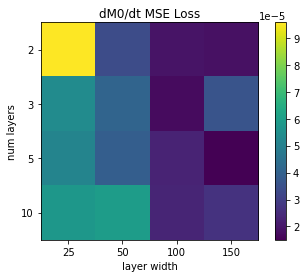

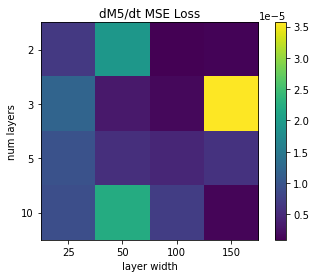

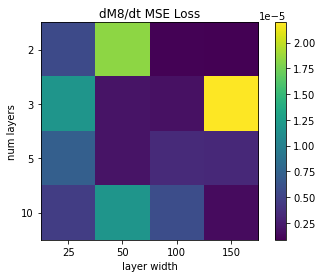

In [63]:
df = pd.read_csv('4-moment-MSE-1spaced-hyperparams2.csv')

df1 = df.loc[(df['activation'] == 'ReLU') & (df['init_lr'] == 0.0001) & (df['weight_decay'] == 1.000000e-08)]

print(df1)

M0perf = pd.DataFrame(index=[2,3,5,10], columns=[25,50,100,150])
M5perf = pd.DataFrame(index=[2,3,5,10], columns=[25,50,100,150])
M8perf = pd.DataFrame(index=[2,3,5,10], columns=[25,50,100,150])
for idx,row in df1.iterrows():
    M0perf.at[row['layers'], row['layer_width']] = float(row['Value 1'])
    M5perf.at[row['layers'], row['layer_width']] = float(row['Value 2'])
    M8perf.at[row['layers'], row['layer_width']] = float(row['Value 3'])    

plt.imshow(M0perf.to_numpy(dtype='float'))
plt.colorbar()
plt.xticks(range(len(M0perf)), M0perf.columns)
plt.yticks(range(len(M0perf)), M0perf.index)
plt.xlabel('layer width')
plt.ylabel('num layers')
plt.title('dM0/dt MSE Loss')
plt.show()

plt.imshow(M5perf.to_numpy(dtype='float'))
plt.colorbar()
plt.xticks(range(len(M5perf)), M5perf.columns)
plt.yticks(range(len(M5perf)), M5perf.index)
plt.xlabel('layer width')
plt.ylabel('num layers')
plt.title('dM5/dt MSE Loss')
plt.show()

plt.imshow(M8perf.to_numpy(dtype='float'))
plt.colorbar()
plt.xticks(range(len(M8perf)), M8perf.columns)
plt.yticks(range(len(M8perf)), M8perf.index)
plt.xlabel('layer width')
plt.ylabel('num layers')
plt.title('dM8/dt MSE Loss')
plt.show()

In [14]:
#read in the data in the csv file for 4 moments into performance matrix

file = open('4-moment-MSE-1spaced-hyperparams2.csv')
csvreader = csv.reader(file)
header = next(csvreader)

#data structure used for plotting the data
performanceM0 = np.zeros(shape=(16,16))
performanceMi = np.zeros(shape=(16,16))
performanceMj = np.zeros(shape=(16,16))
#select whether the rows come directly from the just generated dataArray or from an external file
rows = csvreader
#rows = dataArray.tolist()

for row in rows:
    performanceM0[int(row[1])+3,int(row[2])+3] = float(row[3])
    performanceMi[int(row[0])+3,int(row[2])+3] = float(row[4])
    performanceMj[int(row[0])+3,int(row[1])+3] = float(row[5])
    #performance[int(row[2])+3,int(row[1])+3] = float(row[3])


[0, 3, 4, 9] was the best for predicting dM0/dt


/burg/glab/users/raa2218/envs/geo_scipy_torch/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


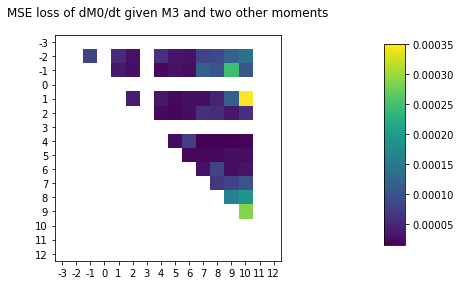

In [15]:
zz = np.ma.masked_where(performanceM0==0,performanceM0)

coords = np.unravel_index(zz.argmin(), zz.shape)
a=list(map(lambda x: x-3, coords))
print([0,3]+a,"was the best for predicting dM0/dt")

im = plt.imshow(zz, interpolation='nearest')
plt.xticks(np.arange(0,16), np.arange(-3,13))
plt.yticks(np.arange(0,16), np.arange(-3,13))
fig = plt.gcf()
fig.suptitle('MSE loss of dM0/dt given M3 and two other moments')
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()
plt.savefig('dM0dt_log.png')
plt.show()

In [91]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 7,7